### Model Building 

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from langdetect import detect, detect_langs
import googletrans
from googletrans import Translator
import re
import translate
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from string import digits
import string
from tqdm.keras import TqdmCallback

C:\ProgramData\Anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\gpu_test\lib\site-packages\tensorf

In [2]:
#Import all the required Libraries

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Accuracy
import matplotlib.pyplot as plt
import collections
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

In [3]:
df = pd.read_excel('processed_trimmed_data.xlsx',sheet_name='Sheet1',encoding="utf-8",dtype="str")

In [4]:
maxlen =200
embedding_size = 200
LEARNING_RATE = 1e-3
Units = 128
Drop=0.1
EPOCHS = 150
BATCH_SIZE = 100
#glove=0
numword = 2000
embeddings = {}
embedding_matrix = np.zeros((numword, embedding_size))
t = Tokenizer(num_words=numword)

In [5]:
def prepare_token(data):
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  print("Tokenization process...F1.2..", len(t.word_index)) 
  return (t)

In [6]:
def prepare_data(X,y):
  df_mod_X=X
  t = prepare_token(df_mod_X)
  
  df_mod_X1 = t.texts_to_sequences(df_mod_X)
  df_mod_X2 = pad_sequences(df_mod_X1, maxlen=200, padding = 'post', truncating = 'post')
  values = y
  
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  df_mod_y=onehot_encoded
  
  print("Group Count:",len(y.value_counts()))
  Groups = len(y.value_counts())
  
  # Split features into training and validation sets
  X_train, X_valid, y_train, y_valid = train_test_split(df_mod_X2, df_mod_y, test_size=0.20, random_state=42)
  
  # Print the share of the training and validation sets
  print("Shape of Training set :",X_train.shape," / ", y_train.shape)
  print("Shape of Validation set :",X_valid.shape," / ", y_valid.shape)
  
  if glove ==1:
  #  print("Start glove Process F1.3")    
    embedding_matrix = Glv_model(X,t)
  return (X_train, X_valid, y_train, y_valid,Groups,embedding_matrix)

In [7]:
def prepare_Model(glove):
  #print("Preparing model...",t.num_words)
  model = Sequential()
  print("preparing Model Embedding shape: ", embedding_matrix.shape)  
  if glove == 1 :
        model.add(Embedding(t.num_words, embedding_size,weights = [embedding_matrix],input_length = maxlen, trainable = False, name='L1_Embedding'))
  else :
        model.add(Embedding(t.num_words, embedding_size,input_length = maxlen, trainable = False, name='L1_Embedding'))
  model.add(LSTM(128, return_sequences = True, dropout = 0.2))
  model.add(Flatten(name='L3_Flatten'))
  model.add(Dense(254, activation='relu',name='L4_Dense_relu'))
  model.add(Dense(Groups, activation='sigmoid',name='L6_Dense_sigmoid'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
  model.summary()
  #callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
  callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
  history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid), verbose=0, batch_size=BATCH_SIZE, callbacks= callbacks)
  return(history)

In [8]:
def Glv_model(data,t):
  #print("Preparing GloVe vector...F1.3 .. token as input", len(t.word_index))
  embeddings = {}  
  if len(embeddings)==0:
    EMBEDDING_FILE = 'glove.6B.200d.txt'
    embeddings = dict()
    f = open('glove.6B.200d.txt',encoding='Latin-1')
    for line in (f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings[word] = coefs
    f.close()
  print("Glove being used:",len(embeddings))
  EMBEDDING_FILE = 'glove.6B.200d.txt'
  
  word_index = t.word_index
  print("t.word_index shape", len(t.word_index))  
  nb_words = numword
  embedding_matrix = np.zeros((t.num_words, embedding_size))
  #print("Embedding Matrix Shape : ", embedding_matrix.shape )
  for word, i in (word_index.items()):
    if i < t.num_words:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            #if i < 2 : print(i,embedding_matrix[i])
  return(embedding_matrix)

In [9]:
#Plot the Accuracy and Loss on the graph to represent the trend
def plot_history(history,D,T,Groups):
    fig = plt.figure(figsize = (10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Validation Acc')
    print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups))
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    
    plt.show()

Tokenization process...F1.2.. 5809
Group Count: 74
Shape of Training set : (6698, 200)  /  (6698, 74)
Shape of Validation set : (1675, 200)  /  (1675, 74)
Glove being used: 399955
t.word_index shape 5809
Run Count: 1 / MODEL for : trimmed_words_short / Assignment group / Groups : 74
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
______________________________________________________

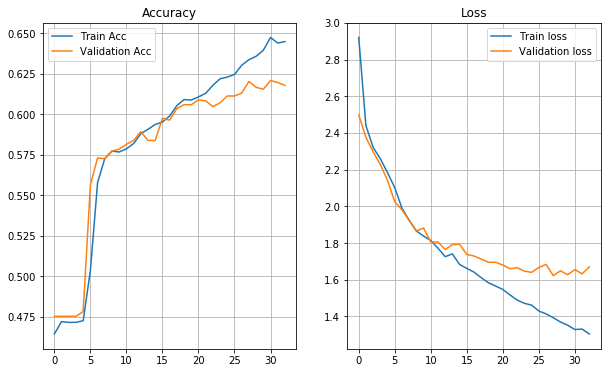

Tokenization process...F1.2.. 5809
Group Count: 10
Shape of Training set : (6698, 200)  /  (6698, 10)
Shape of Validation set : (1675, 200)  /  (1675, 10)
Glove being used: 399955
t.word_index shape 5809
Run Count: 2 / MODEL for : trimmed_words_short / new_group_75 / Groups : 10
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
_______________________________________

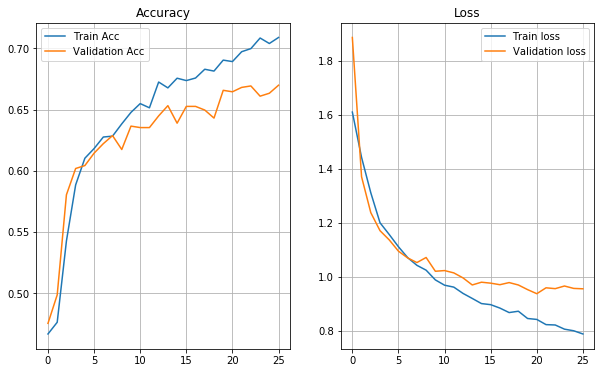

Tokenization process...F1.2.. 5809
Group Count: 18
Shape of Training set : (6698, 200)  /  (6698, 18)
Shape of Validation set : (1675, 200)  /  (1675, 18)
Glove being used: 399955
t.word_index shape 5809
Run Count: 3 / MODEL for : trimmed_words_short / new_group_85 / Groups : 18
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
_______________________________________

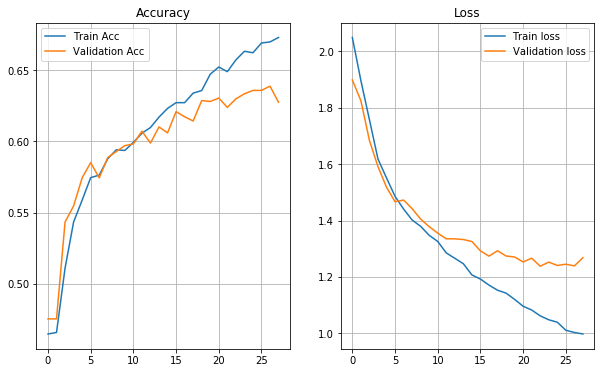

Tokenization process...F1.2.. 5809
Group Count: 36
Shape of Training set : (6698, 200)  /  (6698, 36)
Shape of Validation set : (1675, 200)  /  (1675, 36)
Glove being used: 399955
t.word_index shape 5809
Run Count: 4 / MODEL for : trimmed_words_short / new_group_95 / Groups : 36
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
_______________________________________

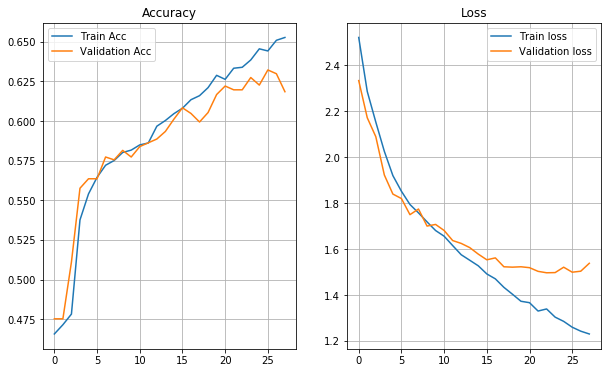

Tokenization process...F1.2.. 12988
Group Count: 74
Shape of Training set : (6698, 200)  /  (6698, 74)
Shape of Validation set : (1675, 200)  /  (1675, 74)
Glove being used: 399955
t.word_index shape 12988
Run Count: 5 / MODEL for : trimmed_words_long / Assignment group / Groups : 74
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_4 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
__________________________________

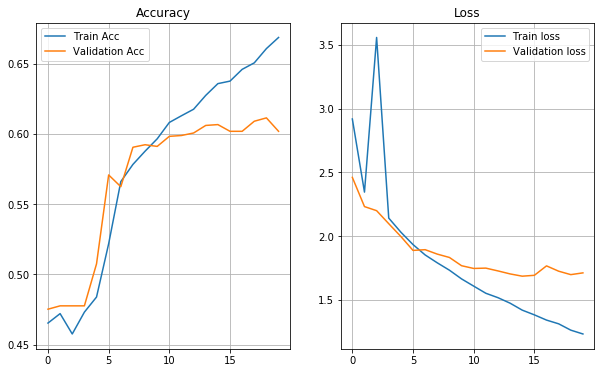

Tokenization process...F1.2.. 12988
Group Count: 10
Shape of Training set : (6698, 200)  /  (6698, 10)
Shape of Validation set : (1675, 200)  /  (1675, 10)
Glove being used: 399955
t.word_index shape 12988
Run Count: 6 / MODEL for : trimmed_words_long / new_group_75 / Groups : 10
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_5 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
______________________________________

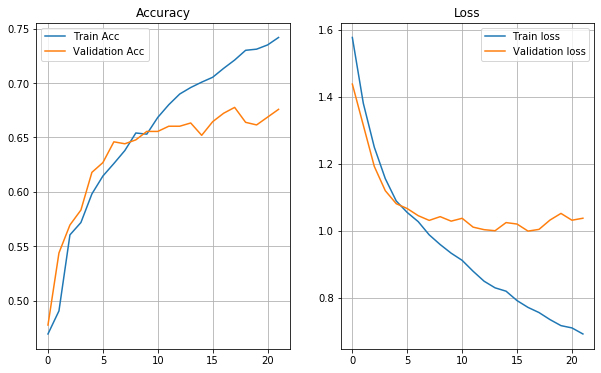

Tokenization process...F1.2.. 12988
Group Count: 18
Shape of Training set : (6698, 200)  /  (6698, 18)
Shape of Validation set : (1675, 200)  /  (1675, 18)
Glove being used: 399955
t.word_index shape 12988
Run Count: 7 / MODEL for : trimmed_words_long / new_group_85 / Groups : 18
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_6 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
______________________________________

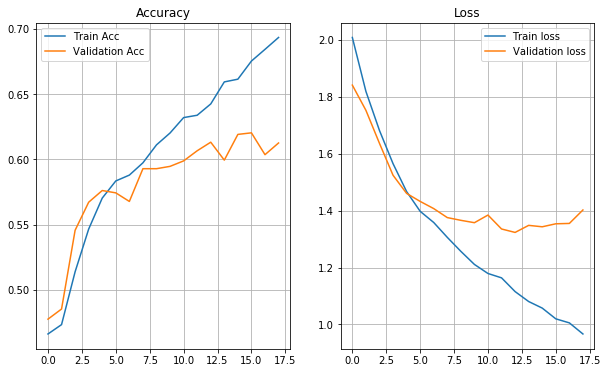

Tokenization process...F1.2.. 12988
Group Count: 36
Shape of Training set : (6698, 200)  /  (6698, 36)
Shape of Validation set : (1675, 200)  /  (1675, 36)
Glove being used: 399955
t.word_index shape 12988
Run Count: 8 / MODEL for : trimmed_words_long / new_group_95 / Groups : 36
Prepare Model : F2
preparing Model Embedding shape:  (2000, 200)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
unified_lstm_7 (UnifiedLSTM) (None, 200, 128)          168448    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25600)             0         
_________________________________________________________________
L4_Dense_relu (Dense)        (None, 254)               6502654   
______________________________________

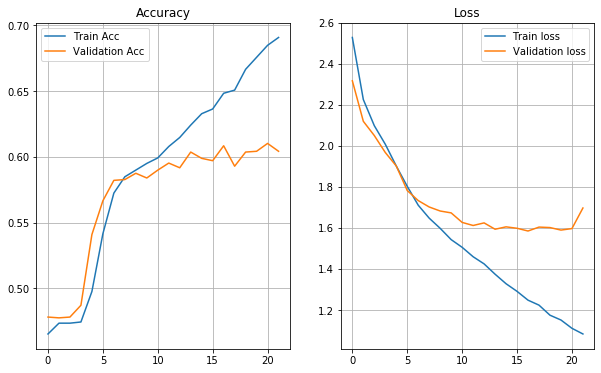

In [10]:
 Dim = ['trimmed_words_short','trimmed_words_long']
 target = ['Assignment group','new_group_75','new_group_85','new_group_95']
 Desc_Col = []
 Group_Col = []
 Dense_group = []
 Train_Acc = []
 Valid_Acc = []
 Train_Loss = []
 Valid_Loss = []
 n=1
 glove=1
 for D in Dim:
   for T in target:
     if n>=10:
       break
     #print("Prepare data : F1")
     X_train,X_valid,y_train,y_valid,Groups,embedding_matrix = prepare_data(df[D],df[T])
     print("Run Count:",n,"/","MODEL for :",D,"/",T,"/","Groups :",Groups)
     print("Prepare Model : F2")
     history = prepare_Model(glove)
     Desc_Col.append(D)
     Group_Col.append(T)
     Dense_group.append(Groups)
     Train_Acc.append(round(max(history.history['accuracy']),2))
     Valid_Acc.append(round(max(history.history['val_accuracy']),2))
     Train_Loss.append(round(max(history.history['loss']),2))
     Valid_Loss.append(round(max(history.history['val_loss']),2))
     #print(D,"  ",T)
     plot_history(history,D,T,Groups)
     n=n+1


In [11]:
Results =[]
Results = pd.DataFrame(
    { 'Description Col':Desc_Col,
      'Group Col':Group_Col,
      'Dense Group':Dense_group,
      'Training Acc':Train_Acc,
      'Validation Acc':Valid_Acc,
      'Training Loss':Train_Loss,
      'Validation Loss':Valid_Loss
     })
Results

,Description Col,Group Col,Dense Group,Training Acc,Validation Acc,Training Loss,Validation Loss
0,trimmed_words_short,Assignment group,74,0.65,0.62,2.92,2.50
1,trimmed_words_short,new_group_75,10,0.71,0.67,1.61,1.89
2,trimmed_words_short,new_group_85,18,0.67,0.64,2.05,1.90
3,trimmed_words_short,new_group_95,36,0.65,0.63,2.52,2.33
4,trimmed_words_long,Assignment group,74,0.67,0.61,3.56,2.46
5,trimmed_words_long,new_group_75,10,0.74,0.68,1.58,1.44
6,trimmed_words_long,new_group_85,18,0.69,0.62,2.01,1.84
7,trimmed_words_long,new_group_95,36,0.69,0.61,2.53,2.32


In [12]:
Results.to_excel("results.xlsx")